In [1]:
from gensn.distributions import TrainableDistributionAdapter, Joint
from gensn.variational import ELBOMarginal, VariationalDequantizedDistribution
from gensn.parameters import TransformedParameter, PositiveDiagonal, Covariance
from gensn.flow import FlowDistribution
import gensn.transforms.invertible as T
from gensn.transforms.surjective import StepQuantizer
import gensn.distributions as G
import torch.distributions as D

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.optim import Adam

Prepare quantized dataset

In [3]:
z_distr = G.IndependentNormal(torch.Tensor([5]), torch.Tensor([1.0]))

Get samples and quantize

In [4]:
z_samples = z_distr.sample((1000,))

In [5]:
quantizer = StepQuantizer()

In [6]:
x_samples = quantizer(z_samples)

We are going to use flow dequantizer along with simple trainable gaussian as the prior for dequantization

In [7]:
# prepare the flow-based dequantizer. It's important that the dequantizer agrees with the quantizer about the support.
# for dequantizer flow, it's more intuitive to build the flow from base_distribution -> sample and then invert

layers = [
    T.IndependentAffine(),
    T.ELU(),
    T.IndependentAffine(),
    T.ELU(),
    T.IndependentAffine(),
    T.Sigmoid(), # this limits the output to (0, 1)
    T.ConditionalShift(nn.Identity()) # this ensures output falls within (x, x+1)
]
base_to_sample = T.SequentialTransform(*layers)


# Initialize the affine layers
init_std = 0.01
def init_module(module):
    if isinstance(module, T.IndependentAffine):
        module.weight.data.normal_(mean=1.0, std=init_std)
        module.bias.data.zero_()

base_to_sample.apply(init_module)

SequentialTransform(
  (transforms): ModuleList(
    (0): IndependentAffine()
    (1): ELU()
    (2): IndependentAffine()
    (3): ELU()
    (4): IndependentAffine()
    (5): Sigmoid()
    (6): ConditionalShift(
      (conditional_shift): Identity()
    )
  )
)

In [8]:
with torch.no_grad():
    x = torch.linspace(-5, 5, 1000)[:, None]
    z, _ = base_to_sample.forward(x, cond=torch.Tensor([[5.0]]))
    x_rec, _ = base_to_sample.inverse(z, cond=torch.Tensor([[5.0]]))


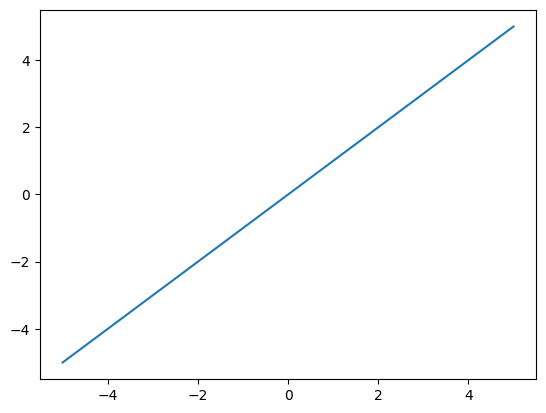

In [9]:
plt.plot(x.flatten(), x_rec.flatten())

In [10]:
# we create the base distribution to be conditionally dependent on discretized value
class CondScale(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(1, 1)
    def forward(self, x):
        return self.lin(x)**2

flow_base_distr = G.IndependentNormal(nn.Linear(1,1), CondScale())

def init(module):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(std=init_std)
        module.bias.data.zero_()

flow_base_distr.apply(init)
#flow_base_distr = G.IndependentNormal(nn.Parameter(torch.Tensor([0.0])), TransformedParameter(torch.Tensor([1.0]), lambda x: x**2))


IndependentNormal(
  (trainable_distribution): TrainableDistributionAdapter(
    (loc): Linear(in_features=1, out_features=1, bias=True)
    (scale): CondScale(
      (lin): Linear(in_features=1, out_features=1, bias=True)
    )
  )
)

In [11]:
# now build the flow distribution. Remember to inverse the transform
flow_dequant = FlowDistribution(flow_base_distr, T.InverseTransform(base_to_sample))

In [12]:
# prepare the prior distribution over dequantized value. Here we'll use simple trainable Gaussian
dequant_distr = G.IndependentNormal(nn.Parameter(torch.Tensor([0.0])), TransformedParameter(torch.Tensor([1.0]), lambda x: x**2))

In [13]:
model_distr = VariationalDequantizedDistribution(dequant_distr, flow_dequant, quantizer)

In [14]:
optim = Adam(model_distr.parameters(), lr=0.1)

In [15]:
for _ in range(1000):
    optim.zero_grad()
    # target_samples = target_distr.sample((1000,))
    # target_logL = target_distr.log_prob(target_samples).mean()
    nll = -model_distr(x_samples).mean()
    print(f'Model LL: {-nll}')
    nll.backward()
    optim.step()

Model LL: -21.756040573120117
Model LL: -11.35346508026123
Model LL: -8.133871078491211
Model LL: -6.666631698608398
Model LL: -6.269771099090576
Model LL: -6.156767845153809
Model LL: -5.997069835662842
Model LL: -5.86829137802124
Model LL: -5.492547988891602
Model LL: -5.069725513458252
Model LL: -4.574068546295166
Model LL: -4.378303050994873
Model LL: -3.991426944732666
Model LL: -3.728996992111206
Model LL: -3.5458767414093018
Model LL: -3.6501173973083496
Model LL: -3.7013649940490723
Model LL: -3.8775417804718018
Model LL: -3.9303133487701416
Model LL: -3.818394422531128
Model LL: -3.5272812843322754
Model LL: -3.330751419067383
Model LL: -3.199960470199585
Model LL: -3.157508134841919
Model LL: -3.2705652713775635
Model LL: -3.2979977130889893
Model LL: -3.423912286758423
Model LL: -3.4408371448516846
Model LL: -3.3913395404815674
Model LL: -3.252676248550415
Model LL: -3.1657185554504395
Model LL: -3.0852396488189697
Model LL: -3.045846939086914
Model LL: -3.0539166927337646
M

(array([  0.,   0.,   0.,   0.,   0.,   0.,   1.,  28., 140., 327., 360.,
        127.,  17.,   0.]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,
         8.,  9.]),
 <BarContainer object of 14 artists>)

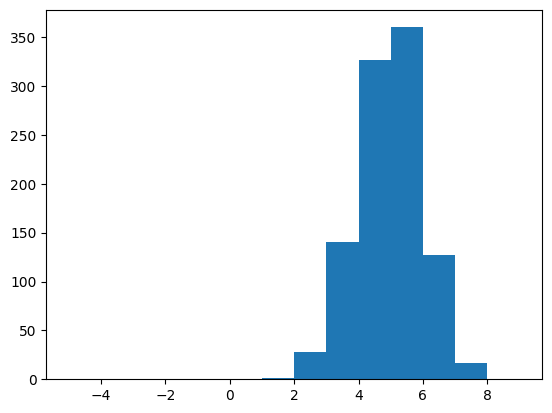

In [16]:
model_x_samples = model_distr.sample((1000,))
plt.hist(model_x_samples.flatten(), bins=np.arange(-5, 10))

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,  19., 133., 349., 352.,
        132.,  13.,   2.]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,
         8.,  9.]),
 <BarContainer object of 14 artists>)

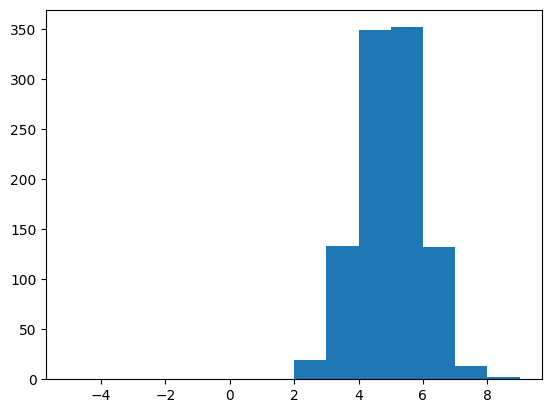

In [17]:
model_x_samples = model_distr.dequantized_distribution.sample((1000,))
plt.hist(model_x_samples.flatten(), bins=np.arange(-5, 10))

In [18]:
x_samples[:5]

tensor([[4.],
        [5.],
        [5.],
        [5.],
        [4.]])

In [19]:
z_samples = model_distr.dequantizer.sample((1,), cond=x_samples[0:5])

In [20]:
z_samples

tensor([[[4.9940],
         [5.5782],
         [5.8784],
         [5.6495],
         [4.7996]]], grad_fn=<AddBackward0>)

In [21]:
z = torch.linspace(0, 10, 1000)[:, None]

In [22]:
with torch.no_grad():
    z_samples = model_distr.dequantizer.sample((1000,), cond=x_samples[0])

In [23]:
x_samples[0]

tensor([4.])

(array([ 65.,  80.,  94.,  85.,  93.,  93.,  98., 105., 141., 146.]),
 array([4.02754211, 4.12448931, 4.2214365 , 4.31838369, 4.41533089,
        4.51227856, 4.60922575, 4.70617294, 4.80312014, 4.90006733,
        4.99701452]),
 <BarContainer object of 10 artists>)

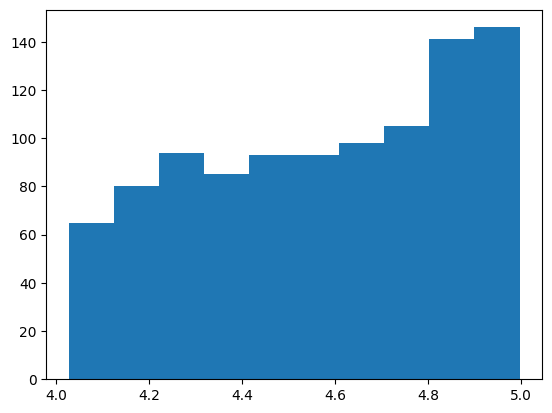

In [24]:
plt.hist(z_samples.flatten())

In [25]:
with torch.no_grad():
    v = model_distr.dequantizer.log_prob(z, cond=x_samples[0])

In [26]:
model_distr.dequantized_distribution

IndependentNormal(
  (trainable_distribution): TrainableDistributionAdapter(
    (scale): TransformedParameter()
  )
)

In [27]:
with torch.no_grad():
    z = torch.linspace(5,6,1000)[:, None]
    x, logdet = model_distr.dequantizer.transform(z, cond=x_samples[0])

In [28]:
with torch.no_grad():
    z_rec, _ = model_distr.dequantizer.transform.inverse(x, cond=x_samples[0])

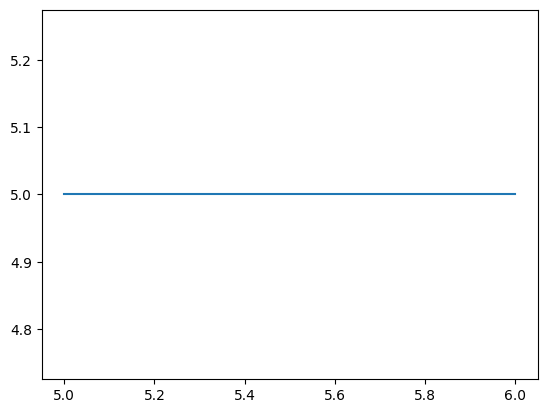

In [29]:
plt.plot(z.flatten(), z_rec.flatten())

In [30]:
np.exp(logdet.mean())

tensor(6572822.)

In [31]:
1 / ((z.max() - z.min()) / (x.max() - x.min()))

tensor(0.)

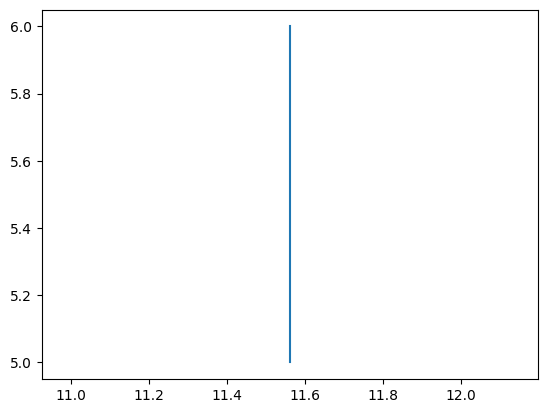

In [32]:
plt.plot(x.flatten(), z.flatten())

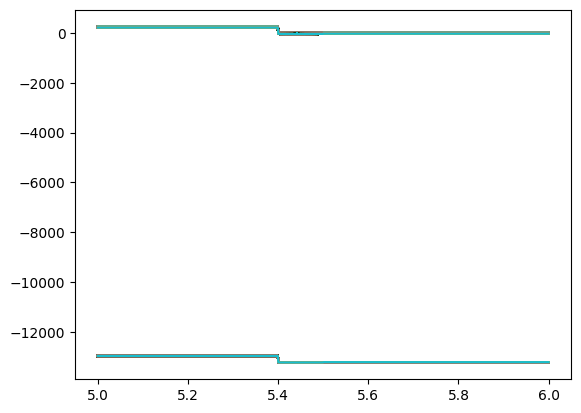

In [33]:
plt.plot(z, v)

In [34]:
z_prob = model_distr.dequantizer.log_prob(z, cond=x_samples[0])

In [35]:
model_distr.dequantizer.log_prob(z_samples, cond=x_samples[:5])

RuntimeError: The size of tensor a (1000) must match the size of tensor b (5) at non-singleton dimension 0

In [36]:
model_distr.state_dict()

OrderedDict([('dequantized_distribution.trainable_distribution.loc',
              tensor([4.9700])),
             ('dequantized_distribution.trainable_distribution.scale.parameter',
              tensor([0.9922])),
             ('dequantizer.base_distribution.trainable_distribution.loc.weight',
              tensor([[-0.3643]])),
             ('dequantizer.base_distribution.trainable_distribution.loc.bias',
              tensor([0.8937])),
             ('dequantizer.base_distribution.trainable_distribution.scale.lin.weight',
              tensor([[-0.0036]])),
             ('dequantizer.base_distribution.trainable_distribution.scale.lin.bias',
              tensor([-1.1286])),
             ('dequantizer.transform.transform.transforms.0.weight',
              tensor([0.4202])),
             ('dequantizer.transform.transform.transforms.0.bias',
              tensor([2.1729])),
             ('dequantizer.transform.transform.transforms.2.weight',
              tensor([1.4761])),
         